In [6]:
from openvino.inference_engine import IENetwork, IECore
import numpy as np
import cv2

In [7]:
ie = IECore()

In [8]:
net = ie.read_network('segmentation_demo/semantic-segmentation-adas-0001.xml',
                      'segmentation_demo/semantic-segmentation-adas-0001.bin')

In [9]:
input_blob = next(iter(net.input_info))
out_blob = next(iter(net.outputs))
input_blob, out_blob

('data', '4119.1')

In [42]:
n, c, h, w = net.input_info[input_blob].input_data.shape
n, c, h, w

(1, 3, 1024, 2048)

In [16]:
images = np.ndarray(shape=(n, c, h, w))
for i in range(n):
    image = cv2.imread('segmentation_demo/ppl.jpeg')
    if image.shape[:-1] != (h, w):
        image = cv2.resize(image, (w, h))
    image = image.transpose((2, 0, 1))  # Change data layout from HWC to CHW
    images[i] = image

In [17]:
exec_net = ie.load_network(network=net, device_name='CPU')

In [23]:
res = exec_net.infer(inputs={input_blob: images})
res = res[out_blob]

In [24]:
images.shape, res.shape

((1, 3, 1024, 2048), (1, 1, 1024, 2048))

In [25]:
if len(res.shape) == 3:
    res = np.expand_dims(res, axis=1)
if len(res.shape) == 4:
    _, _, out_h, out_w = res.shape

In [26]:
classes_color_map = [
    (150, 150, 150),
    (58, 55, 169),
    (211, 51, 17),
    (157, 80, 44),
    (23, 95, 189),
    (210, 133, 34),
    (76, 226, 202),
    (101, 138, 127),
    (223, 91, 182),
    (80, 128, 113),
    (235, 155, 55),
    (44, 151, 243),
    (159, 80, 170),
    (239, 208, 44),
    (128, 50, 51),
    (82, 141, 193),
    (9, 107, 10),
    (223, 90, 142),
    (50, 248, 83),
    (178, 101, 130),
    (71, 30, 204)
]

In [29]:
import os

for batch, data in enumerate(res):
    classes_map = np.zeros(shape=(out_h, out_w, 3), dtype=np.int)
    for i in range(out_h):
        for j in range(out_w):
            if len(data[:, i, j]) == 1:
                pixel_class = int(data[:, i, j])
            else:
                pixel_class = np.argmax(data[:, i, j])
            classes_map[i, j, :] = classes_color_map[min(pixel_class, 20)]
    out_img = "out_{}.bmp".format(batch)
    cv2.imwrite(out_img, classes_map)

In [30]:
import matplotlib.pyplot as plt

(333, 500, 3)


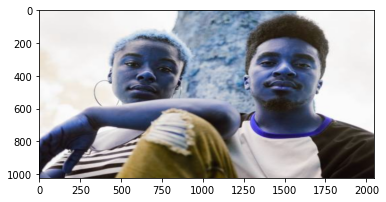

In [52]:
image = cv2.imread('segmentation_demo/ppl.jpeg')
print(image.shape)
plt.imshow(cv2.resize(image, (w, h)))

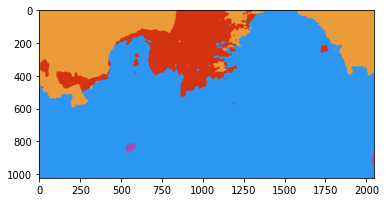

In [53]:
out_im = cv2.imread('out_0.bmp')
plt.imshow(out_im)

In [57]:
res[0, 0, :, :].shape

(1024, 2048)

In [60]:
picker = np.copy(cv2.resize(image, (w,h)))
mask = np.array([res != 12, res ])
picker[res[0, 0, :, :] != 11] = 0

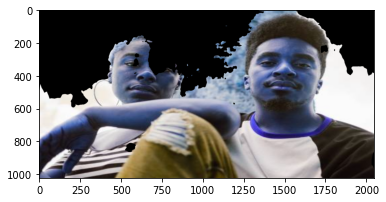

In [61]:
plt.imshow(picker)

## Instance Segmentation Example

In [1]:
from openvino.inference_engine import IENetwork, IECore
from instance_segmentation_demo.instance_segmentation_demo.visualizer import Visualizer
from instance_segmentation_demo.instance_segmentation_demo.tracker import StaticIOUTracker
import numpy as np
import cv2

with open('./instance_segmentation_demo/coco_labels.txt', 'rt') as labels_file:
    class_labels = labels_file.read().splitlines()

tracker = StaticIOUTracker()
visualizer = Visualizer(class_labels, show_boxes=True, show_scores=True)
ie = IECore()

/home/reyes/miniconda3/envs/freyes/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'openvino.inference_engine.ie_api' does not match runtime version 3.7
  return f(*args, **kwds)
/home/reyes/miniconda3/envs/freyes/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'openvino.inference_engine.constants' does not match runtime version 3.7
  return f(*args, **kwds)


In [2]:
net = ie.read_network('instance_segmentation_demo/instance-segmentation-security-1025.xml',
                      'instance_segmentation_demo/instance-segmentation-security-1025.bin')

In [3]:
input_blob = next(iter(net.input_info))
out_blob = next(iter(net.outputs))
input_blob, out_blob

('im_data', 'boxes')

In [4]:
n, c, h, w = net.input_info['im_data'].input_data.shape

In [5]:
exec_net = ie.load_network(network=net, device_name='CPU')

In [6]:
frame = cv2.imread('segmentation_demo/ppl.jpeg')

def preprocess(frame):
    scale_x = scale_y = min(h / frame.shape[0], w / frame.shape[1])
    input_image = cv2.resize(frame, None, fx=scale_x, fy=scale_y)
    
    input_image_size = input_image.shape[:2]
    input_image = np.pad(input_image, ((0, h - input_image_size[0]),
                                       (0, w - input_image_size[1]),
                                       (0, 0)),
                         mode='constant', constant_values=0)
    # Change data layout from HWC to CHW.
    input_image = input_image.transpose((2, 0, 1))
    input_image = input_image.reshape((n, c, h, w)).astype(np.float32)
    input_image_info = np.asarray(
        [[input_image_size[0], input_image_size[1], 1]], dtype=np.float32
    )
    
    return {'im_data': input_image, 'im_info': input_image_info}, frame, scale_x, scale_y

In [7]:
input_dict, frame, scale_x, scale_y = preprocess(frame)
outputs = exec_net.infer(input_dict)

In [8]:
def segm_postprocess(box, raw_cls_mask, im_h, im_w):
    # Add zero border to prevent upsampling artifacts on segment borders.
    raw_cls_mask = np.pad(raw_cls_mask, ((1, 1), (1, 1)), 'constant', constant_values=0)
    extended_box = expand_box(box, raw_cls_mask.shape[0] / (raw_cls_mask.shape[0] - 2.0)).astype(int)
    w, h = np.maximum(extended_box[2:] - extended_box[:2] + 1, 1)
    x0, y0 = np.clip(extended_box[:2], a_min=0, a_max=[im_w, im_h])
    x1, y1 = np.clip(extended_box[2:] + 1, a_min=0, a_max=[im_w, im_h])

    raw_cls_mask = cv2.resize(raw_cls_mask, (w, h)) > 0.5
    mask = raw_cls_mask.astype(np.uint8)
    # Put an object mask in an image mask.
    im_mask = np.zeros((im_h, im_w), dtype=np.uint8)
    im_mask[y0:y1, x0:x1] = mask[(y0 - extended_box[1]):(y1 - extended_box[1]),
                            (x0 - extended_box[0]):(x1 - extended_box[0])]
    return im_mask

def expand_box(box, scale):
    w_half = (box[2] - box[0]) * .5
    h_half = (box[3] - box[1]) * .5
    x_c = (box[2] + box[0]) * .5
    y_c = (box[3] + box[1]) * .5
    w_half *= scale
    h_half *= scale
    box_exp = np.zeros(box.shape)
    box_exp[0] = x_c - w_half
    box_exp[2] = x_c + w_half
    box_exp[1] = y_c - h_half
    box_exp[3] = y_c + h_half
    return box_exp

In [9]:
def post_process(frame, outputs, scale_x, scale_y):
    boxes = outputs['boxes']
    boxes[:, 0::2] /= scale_x
    boxes[:, 1::2] /= scale_y
    scores = outputs['scores']
    classes = outputs['classes'].astype(np.uint32)
    
    masks = []
    for box, cls, raw_mask in zip(boxes, classes, outputs['raw_masks']):
        raw_cls_mask = raw_mask[cls, ...]
        mask = segm_postprocess(
            box, raw_cls_mask, frame.shape[0], frame.shape[1]
        )
        masks.append(mask)

    # Filter out detections with low confidence.
    detections_filter = scores > 0
    scores = scores[detections_filter]
    classes = classes[detections_filter]
    boxes = boxes[detections_filter]
    masks = list(
        segm for segm, is_valid in zip(masks, detections_filter) if is_valid
    )
    picker = np.copy(frame)
    picker[masks[0] == 0] = 0
    return picker, masks[0] == 0

In [10]:
import matplotlib.pyplot as plt

(<matplotlib.image.AxesImage at 0x7f5280887590>, (333, 500, 3))

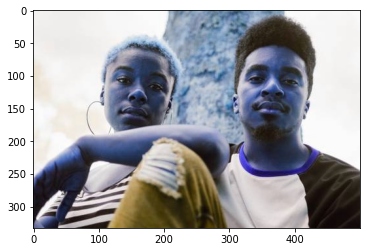

In [11]:
plt.imshow(frame), frame.shape

(<matplotlib.image.AxesImage at 0x7f527eb67310>, (333, 500, 3))

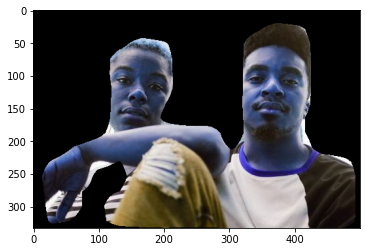

In [12]:
picker, picker_mask = post_process(frame, outputs, scale_x, scale_y)
plt.imshow(picker), picker.shape

## Depth Image Data Segmentation

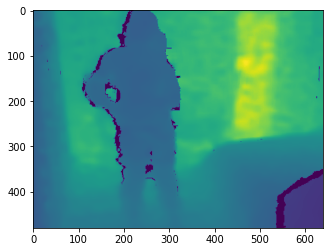

In [13]:
calib_depth = np.load('depth_data/test_depth.npy')
plt.imshow(calib_depth)

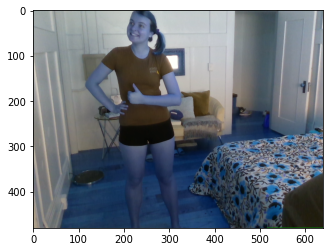

In [14]:
color_image = np.load('depth_data/test_color_image.npy')
plt.imshow(color_image)

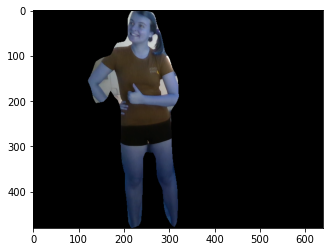

In [15]:
input_dict, color_image, scale_x, scale_y = preprocess(color_image)
outputs = exec_net.infer(input_dict)
picker, picker_mask = post_process(color_image, outputs, scale_x, scale_y)
plt.imshow(picker)

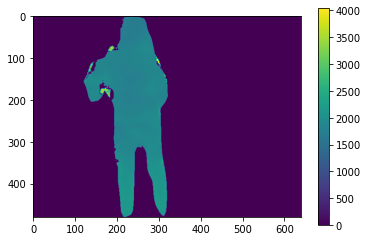

In [18]:
calib_depth_ppl = np.copy(calib_depth)
calib_depth_ppl[picker_mask] = 0
d = plt.imshow(calib_depth_ppl)
plt.colorbar(d)